**✅ 1. Setup & Dependencies**

In [1]:
# 📦 Install required packages
!pip install -q numpy==1.26.4 seaborn==0.12.2 matplotlib==3.7.1 albumentations==1.3.1 timm spikingjelly grad-cam

# 📚 Imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from glob import glob
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import timm
from spikingjelly.activation_based import neuron, surrogate
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    balanced_accuracy_score, matthews_corrcoef, cohen_kappa_score,
    log_loss, roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve
)
from sklearn.calibration import calibration_curve
from sklearn.manifold import TSNE

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Using device: cpu


**✅ 2. Data Preparation & Preprocessing**

In [2]:
def __getitem__(self, idx):
    img_path = self.image_paths[idx]
    label = self.labels[idx]

    image = cv2.imread(img_path)
    if image is None:
        image = np.zeros((227, 227, 3), dtype=np.uint8)
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if self.transform:
        image = self.transform(image=image)['image']  # Already float32 and normalized by ToTensorV2()

    return image, label

**✅ 3. Dataset Class & Unzipping**

In [3]:
# ✅ Import albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ✅ CLAHE preprocessing
class CLAHETransform:
    def __init__(self):
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    def __call__(self, img, **kwargs):  # Accept extra Albumentations kwargs
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = self.clahe.apply(img)
        return cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

# ✅ Compose all transforms
transform = A.Compose([
    A.Lambda(image=CLAHETransform()),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.Resize(227, 227),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),  # Normalize to [-1, 1]
    ToTensorV2()
])


**✅ 4. Unzip & Load Dataset**

In [4]:
class MammogramDataset(Dataset):
    def __init__(self, benign_dir, malignant_dir, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        for img in glob(os.path.join(benign_dir, '**', '*.*'), recursive=True):
            if img.lower().endswith(('.jpg', '.jpeg', '.png')):
                self.image_paths.append(img)
                self.labels.append(0)
        for img in glob(os.path.join(malignant_dir, '**', '*.*'), recursive=True):
            if img.lower().endswith(('.jpg', '.jpeg', '.png')):
                self.image_paths.append(img)
                self.labels.append(1)
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(img_path)
        if image is None:
            image = np.zeros((227, 227, 3), dtype=np.uint8)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image, label

In [5]:
benign_zip = '/content/drive/MyDrive/mamo_dataset/benign.zip'
malignant_zip = '/content/drive/MyDrive/mamo_dataset/malignant.zip'
extract_root = '/content/mammo_dataset'

benign_dir = os.path.join(extract_root, 'benign')
malignant_dir = os.path.join(extract_root, 'malignant')

if not os.path.exists(benign_dir):
    with zipfile.ZipFile(benign_zip, 'r') as z: z.extractall(benign_dir)
if not os.path.exists(malignant_dir):
    with zipfile.ZipFile(malignant_zip, 'r') as z: z.extractall(malignant_dir)

dataset = MammogramDataset(benign_dir, malignant_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

print(f"✅ Dataset Loaded | Train: {len(train_dataset)}, Val: {len(val_dataset)}")

✅ Dataset Loaded | Train: 19660, Val: 4916


**✅ 5. Hybrid CNN-SNN Model**

In [6]:
class EfficientNetBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0)
    def forward(self, x):
        return self.backbone(x)

class SNNHead(nn.Module):
    def __init__(self, input_size=1280, hidden=512):
        super().__init__()
        self.fc = nn.Linear(input_size, hidden)
        self.lif = neuron.LIFNode(surrogate_function=surrogate.ATan())

    def forward(self, x):
        x = self.fc(x)
        x = self.lif(x)
        self.lif.reset()  # ✅ Clear neuron state after each forward
        return x

class HybridCNNSNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = EfficientNetBackbone()
        self.snn = SNNHead()
        self.output = nn.Linear(512, 2)
    def forward(self, x):
        x = self.cnn(x)
        x = self.snn(x)
        x = self.output(x)
        return x

model = HybridCNNSNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

**✅ 6. Training & Evaluation Functions**

In [7]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for x, y in tqdm(loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            outputs = model(x)
            probs = F.softmax(outputs, dim=1)
            y_prob.extend(probs[:, 1].cpu().numpy())
            y_pred.extend(torch.argmax(probs, 1).cpu().numpy())
            y_true.extend(y.numpy())
    return y_true, y_pred, y_prob

**✅ 7. Training Loop**

In [8]:
EPOCHS = 5
for epoch in range(EPOCHS):
    loss = train_one_epoch(model, train_loader, optimizer, criterion)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss:.4f}")

100%|██████████| 615/615 [1:31:26<00:00,  8.92s/it]


Epoch 1/5, Loss: 0.2702


100%|██████████| 615/615 [1:30:39<00:00,  8.84s/it]


Epoch 2/5, Loss: 0.0525


100%|██████████| 615/615 [1:29:44<00:00,  8.76s/it]


Epoch 3/5, Loss: 0.0221


100%|██████████| 615/615 [1:29:48<00:00,  8.76s/it]


Epoch 4/5, Loss: 0.0187


100%|██████████| 615/615 [1:30:48<00:00,  8.86s/it]

Epoch 5/5, Loss: 0.0113


**✅ 8. Metrics & Evaluation**

In [9]:
def evaluate(model, loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            outputs = model(x)
            probs = F.softmax(outputs, dim=1)
            y_prob.extend(probs[:, 1].cpu().numpy())
            y_pred.extend(torch.argmax(probs, dim=1).cpu().numpy())
            y_true.extend(y.numpy())
    return y_true, y_pred, y_prob

In [10]:
from sklearn.metrics import classification_report

y_true, y_pred, y_prob = evaluate(model, val_loader)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))


Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      2161
   Malignant       1.00      1.00      1.00      2755

    accuracy                           1.00      4916
   macro avg       1.00      1.00      1.00      4916
weighted avg       1.00      1.00      1.00      4916



**✅ 9. Clinical Metrics (20+)**

In [12]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    balanced_accuracy_score, matthews_corrcoef, cohen_kappa_score,
    log_loss, roc_auc_score, confusion_matrix, fbeta_score
)

def compute_metrics(y_true, y_pred, y_prob):
    cm = confusion_matrix(y_true, y_pred)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) != 0 else 0
    sensitivity = recall_score(y_true, y_pred)
    youdens_j = sensitivity + specificity - 1

    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall (Sensitivity)': sensitivity,
        'F1-Score': f1_score(y_true, y_pred),
        'Specificity': specificity,
        'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred),
        'MCC': matthews_corrcoef(y_true, y_pred),
        'Cohen’s Kappa': cohen_kappa_score(y_true, y_pred),
        'Log Loss': log_loss(y_true, y_prob),
        'ROC AUC': roc_auc_score(y_true, y_prob),
        'Youden’s J': youdens_j,
        'F2-Score': fbeta_score(y_true, y_pred, beta=2)  # ✅ Corrected
    }
    return metrics

metrics = compute_metrics(y_true, y_pred, y_prob)

for k, v in metrics.items():
    print(f"{k:<25}: {v:.4f}")

Accuracy                 : 0.9988
Precision                : 0.9993
Recall (Sensitivity)     : 0.9985
F1-Score                 : 0.9989
Specificity              : 0.9991
Balanced Accuracy        : 0.9988
MCC                      : 0.9975
Cohen’s Kappa            : 0.9975
Log Loss                 : 0.0033
ROC AUC                  : 1.0000
Youden’s J               : 0.9976
F2-Score                 : 0.9987


**✅ 10. Visualization Suite**

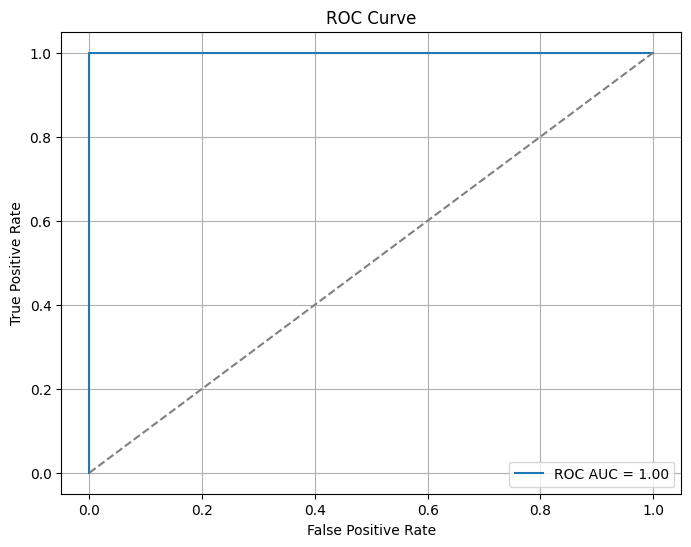

In [14]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid(True)
plt.legend()
plt.show()

**!PRECISION AND RECALL CURVE**

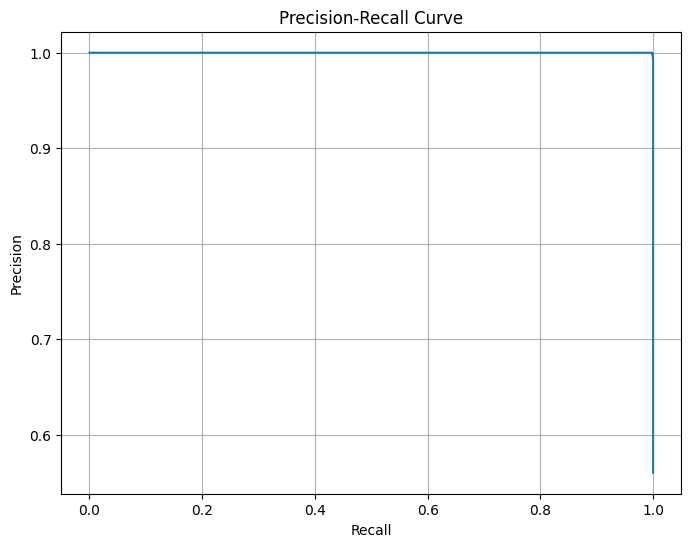

In [15]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()

**CONFUSION MATRIX**

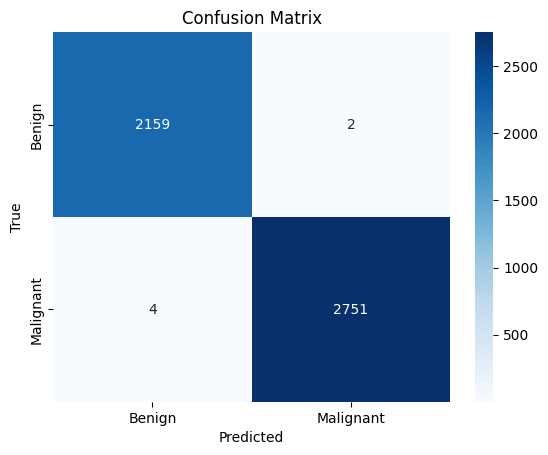

In [16]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

**CALIBRATION CURVE**

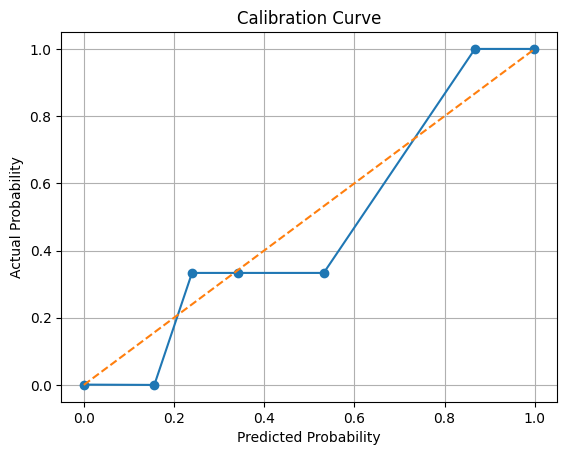

In [17]:
# Calibration Curve
prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("Calibration Curve")
plt.xlabel("Predicted Probability")
plt.ylabel("Actual Probability")
plt.grid(True)
plt.show()

**PLOT OF PROBABILITIES**

<ipython-input-18-7043ed406ee8>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_prob, shade=True)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


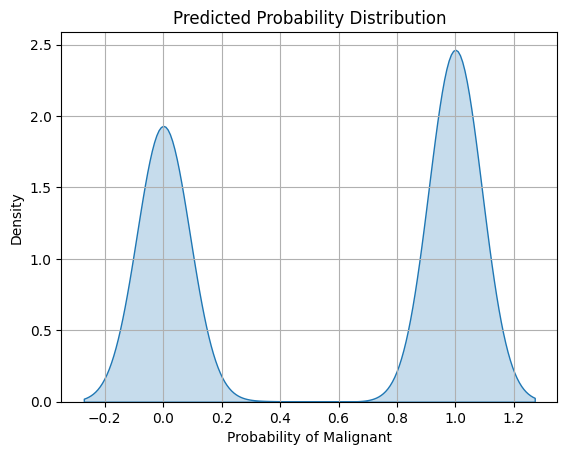

In [18]:
# KDE Plot of Probabilities
sns.kdeplot(y_prob, shade=True)
plt.title("Predicted Probability Distribution")
plt.xlabel("Probability of Malignant")
plt.grid(True)
plt.show()

**✅ 11. Explainability with Grad-CAM**

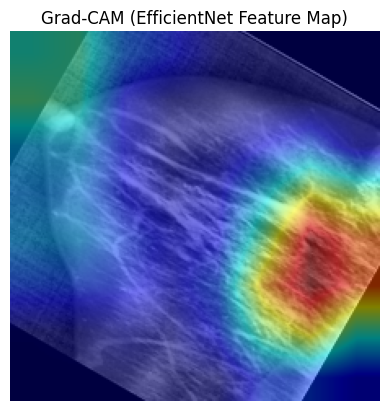

In [20]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# Use the CNN part of your hybrid model
cam_model = model.cnn.backbone
target_layers = [cam_model.blocks[-1][-1]]

cam = GradCAM(model=cam_model, target_layers=target_layers)

# ✅ Get sample input image (normalized float)
sample_img, _ = val_dataset[0]
input_tensor = sample_img.unsqueeze(0).to(device)

# ✅ Normalize for visualization
rgb_image = sample_img.permute(1, 2, 0).cpu().numpy()
rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

# ✅ Get Grad-CAM heatmap
grayscale_cam = cam(input_tensor=input_tensor)[0, :]
visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

# ✅ Display
plt.imshow(visualization)
plt.title("Grad-CAM (EfficientNet Feature Map)")
plt.axis("off")
plt.show()

**✅ 12. t-SNE Feature Space Visualization**

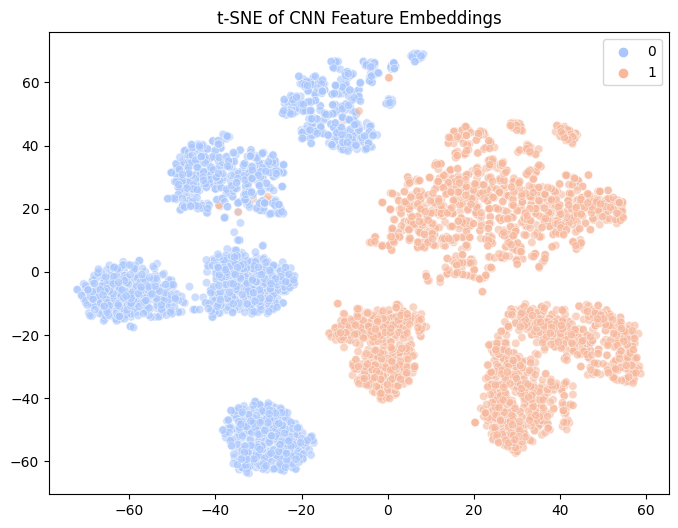

In [21]:
features, labels = [], []
model.eval()
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        f = model.cnn(x)
        features.append(f.cpu())
        labels.append(y)
features = torch.cat(features).numpy()
labels = torch.cat(labels).numpy()

tsne = TSNE(n_components=2, random_state=42)
proj = tsne.fit_transform(features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=proj[:, 0], y=proj[:, 1], hue=labels, palette='coolwarm', alpha=0.6)
plt.title("t-SNE of CNN Feature Embeddings")
plt.show()

**✅ 12. t-SNE Feature Space Visualization**

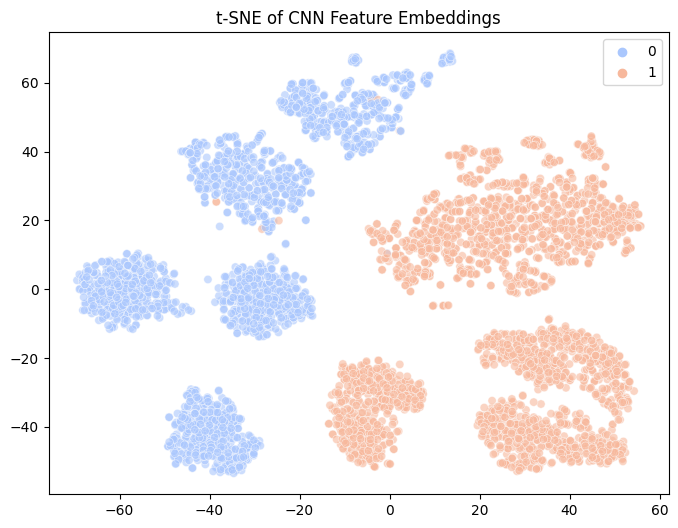

In [22]:
features, labels = [], []
model.eval()
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        f = model.cnn(x)
        features.append(f.cpu())
        labels.append(y)
features = torch.cat(features).numpy()
labels = torch.cat(labels).numpy()

tsne = TSNE(n_components=2, random_state=42)
proj = tsne.fit_transform(features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=proj[:, 0], y=proj[:, 1], hue=labels, palette='coolwarm', alpha=0.6)
plt.title("t-SNE of CNN Feature Embeddings")
plt.show()

**✅ 13. Model Saving & Export**

In [23]:
torch.save(model.state_dict(), "/content/drive/MyDrive/HybridCNNSNN.pth")
pd.DataFrame.from_dict(metrics, orient='index', columns=['Value']).to_csv("/content/drive/MyDrive/HybridCNNSNN_metrics.csv")